This notebook prepares a planet candidate catalog for the stellar population in the specified input stellar catalog.  It computes the reliability, corrected planet radius and includes useful planet properties such as robovetter score.  It outputs two catalogs, one that contains only PCs and one that contains all KOIs.

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack
import pickle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{1 - F_{\mathrm{obsFP}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We get $E$ and $F_{\mathrm{obsFP}}$ from the outputs of the notebooks binomialFPEffectiveness.ipynb and binomialObsFPRate.ipynb.

In [2]:
catalogType = "Berger2020"
# catalogType = "Berger2018comb2019"
# catalogType = "Burke"



In [5]:
# import requests
# from cStringIO import StringIO
# if False:
#     selectStr = "kepid,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,koi_ror,koi_ror_err1,koi_ror_err2"
#     urlDr25Koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_koi&select=" + selectStr

#     r = requests.get(urlDr25Koi)
#     if r.status_code != requests.codes.ok:
#         r.raise_for_status()
#     fh = StringIO(r.content)
#     dr25Koi = pd.read_csv(fh, dtype={"kepoi_name":str})
#     dr25Koi.to_csv("koiCatalogs/dr25_kois_archive.txt", index=False)
# else:
#     dr25Koi = pd.read_csv("../GKbaseline/koiCatalogs/dr25_kois_archive.txt", dtype={"kepoi_name":str})

dr25Koi = pd.read_csv("../GKbaseline/koiCatalogs/dr25_kois_archive.txt", dtype={"kepoi_name":str})

print("Loaded " + str(len(dr25Koi)) + " KOIs")





Loaded 8054 KOIs


In [7]:
# restrict the population to stars in the Travis' catalog

if catalogType == "Berger2020":
    dr25CleanStellarIso = pd.read_csv("../stellarCatalogs/dr25_stellar_Berger2020_dwarfs.txt")
    # dr25CleanStellarIso = pd.read_csv("../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt")
    dr25CleanStellarIso = dr25CleanStellarIso[(dr25CleanStellarIso.Bin == 0)|(dr25CleanStellarIso.Bin == 2)]
    print(str(len(dr25CleanStellarIso)) + " entries after removing marked binaries")
    dr25CleanStellarIso = dr25CleanStellarIso[dr25CleanStellarIso.Evol == 0]
    print(str(len(dr25CleanStellarIso)) + " entries after removing marked evolved stars")
    
    dr25CleanStellarIso = dr25CleanStellarIso[dr25CleanStellarIso.teff <= 7300]
    print(str(len(dr25CleanStellarIso)) + " entries after removing stars hotter than 7300K")
    
    dr25CleanStellarIso.to_csv("dr25_Berger2020_FGKM_dwarfs.txt", index=False)



105118 entries after removing marked binaries
105118 entries after removing marked evolved stars
102071 entries after removing stars hotter than 7300K


In [8]:
dr25Koi = dr25Koi[dr25Koi.kepid.isin(dr25CleanStellarIso.kepid)]
dr25Koi = dr25Koi.reset_index(drop=True)
print("After removing planets not in Travis' list, we have " + str(len(dr25Koi)) + " KOIs")


After removing planets not in Travis' list, we have 4750 KOIs


In [9]:
# merge in only iso_rad and uncertainties from the stellar table

dr25Koi = pd.merge(dr25Koi, dr25CleanStellarIso[["kepid","radius","radius_err1","radius_err2","teff","logg"]], on="kepid", how="inner")


In [10]:
# correct the planet radii with the new catalog

rEarth = 6356.8 # km
rSun = 695700 # km

dr25Koi['corrected_prad'] = dr25Koi['koi_ror']*dr25Koi['radius']*rSun/rEarth;
dr25Koi['corrected_prad_err1'] = np.sqrt(dr25Koi['koi_ror_err1']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err1']**2)*rSun/rEarth;
dr25Koi['corrected_prad_err2'] = -np.sqrt(dr25Koi['koi_ror_err2']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err2']**2)*rSun/rEarth;

dr25Koi = dr25Koi[~np.isnan(dr25Koi.koi_prad)]

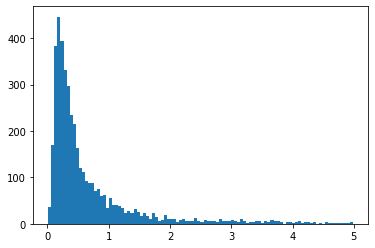

In [11]:
v = dr25Koi.corrected_prad_err1/dr25Koi.koi_prad_err1
plt.hist(v[v<5], 100);

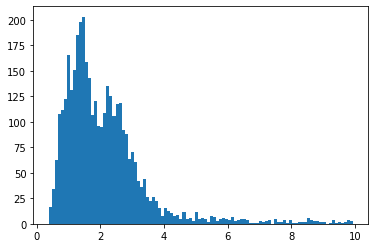

In [12]:
plt.hist(dr25Koi['corrected_prad'][dr25Koi['corrected_prad']<10], 100);

(50.0, 400.0)

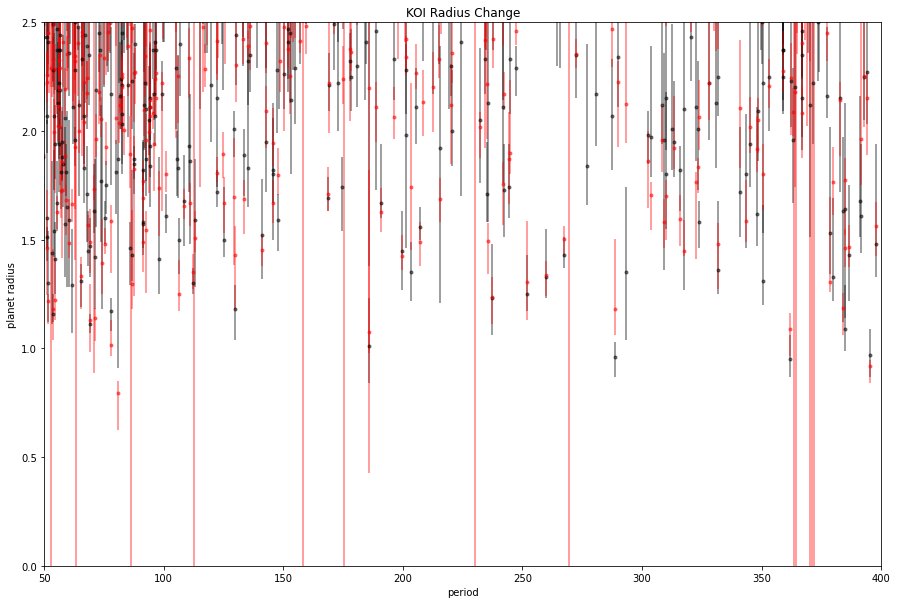

In [13]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25Koi.koi_period, dr25Koi.koi_prad, 
            yerr = [-dr25Koi.koi_prad_err2, dr25Koi.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25Koi.koi_period, dr25Koi.corrected_prad, 
            yerr = [-dr25Koi.corrected_prad_err2, dr25Koi.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])



In [14]:
dr25Fpp = ascii.read("../data/q1_q17_dr25_koifpp.txt")
dr25FppPd = dr25Fpp.to_pandas()

In [15]:
mergedDr25Koi = pd.merge(dr25Koi, dr25FppPd, on="kepoi_name", how="inner")



In [16]:
dr25PC = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "CANDIDATE"]
dr25FP = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "FALSE POSITIVE"]
# remove those with corrected_prad = NAN
dr25PC = dr25PC[~np.isnan(dr25PC.corrected_prad)]
dr25FP = dr25FP[~np.isnan(dr25FP.corrected_prad)]
mergedDr25Koi = mergedDr25Koi[~np.isnan(mergedDr25Koi.corrected_prad)]


print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")


There are 2893 PCs in 102071 observed targets
There are 1831 FPs in 102071 observed targets


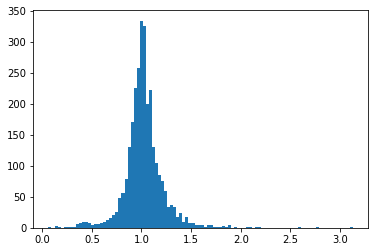

In [17]:
plt.hist(dr25PC.corrected_prad/dr25PC.koi_prad, 100);
#plt.yscale('log', nonposy='clip')



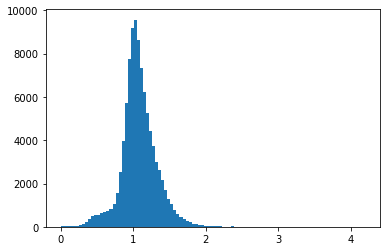

In [18]:
plt.hist(dr25CleanStellarIso.radius[dr25CleanStellarIso.radius<2]/dr25CleanStellarIso.radius_DR25[dr25CleanStellarIso.radius<2], 100);
#plt.yscale('log', nonposy='clip')



In [19]:
if catalogType == "Berger2020":
    dr25PC.to_csv("koiCatalogs/dr25_GK_PCs.csv", index=False)
    mergedDr25Koi.to_csv("koiCatalogs/dr25_GK_KOIs.csv", index=False)


In [20]:
kepler186f = dr25PC[dr25PC.kepoi_name=="K00571.05"]

In [21]:
kepler186f.corrected_prad

3869    1.429029
Name: corrected_prad, dtype: float64

In [22]:
kepler186f.corrected_prad_err1

3869    0.135944
Name: corrected_prad_err1, dtype: float64

In [23]:
kepler186f.corrected_prad_err2

3869   -0.24901
Name: corrected_prad_err2, dtype: float64

In [24]:
kepler186f.koi_prad

3869    1.18
Name: koi_prad, dtype: float64

In [25]:
kepler186f.koi_ror

3869    0.024432
Name: koi_ror, dtype: float64

In [26]:
0.0205*kepler186f['radius']*rSun/rEarth

3869    1.199046
Name: radius, dtype: float64

In [27]:
kepler186f['koi_ror']*0.539*rSun/rEarth

3869    1.441223
Name: koi_ror, dtype: float64

In [28]:
np.sqrt(kepler186f['koi_ror_err2']**2*0.539**2+kepler186f['koi_ror']**2*0.015**2)*rSun/rEarth

3869    0.251155
dtype: float64

In [29]:
dr25PC

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,radius_err2,teff,logg,corrected_prad,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob
1,10854555,K00755.01,1,CANDIDATE,1.000,2.525592,33.191900,2.75,0.88,-0.35,...,0.033878,5659.982592,4.486280,2.401175,0.386208,-0.176139,1273,10854555,2.526,1.000000e-03
2,10872983,K00756.01,1,CANDIDATE,1.000,11.094321,55.204865,3.90,1.27,-0.42,...,0.058554,5850.003018,4.349270,4.452116,0.671612,-0.268642,1274,10872983,11.094,3.600000e-05
3,10872983,K00756.02,2,CANDIDATE,1.000,4.134435,33.546658,2.77,0.90,-0.30,...,0.058554,5850.003018,4.349270,3.163412,0.301539,-0.299876,1275,10872983,4.134,6.300000e-06
4,10872983,K00756.03,3,CANDIDATE,0.992,2.566589,12.325094,1.59,0.52,-0.17,...,0.058554,5850.003018,4.349270,1.813699,0.487983,-0.196573,1276,10872983,2.567,7.800000e-05
5,9579641,K00115.03,3,CANDIDATE,0.871,3.435916,7.433781,0.55,0.08,-0.07,...,0.019940,6023.531921,4.428939,0.516167,0.024433,-0.064030,103,9579641,3.436,4.000000e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719,9458613,K00707.04,4,CANDIDATE,1.000,13.175560,34.928776,2.82,0.43,-0.70,...,0.043696,6183.041575,4.138255,2.692944,0.097098,-0.079180,922,9458613,13.176,1.000000e+00
4720,9458613,K00707.05,5,CANDIDATE,0.997,5.668158,13.906199,1.85,0.28,-0.46,...,0.043696,6183.041575,4.138255,1.765969,0.074771,-0.061498,923,9458613,5.668,NaN
4721,9530945,K00708.01,1,CANDIDATE,1.000,17.406652,57.129204,2.95,0.50,-0.46,...,0.040455,6274.690122,4.144032,3.779871,0.123482,-0.101922,924,9530945,17.407,4.100000e-07
4722,9530945,K00708.02,2,CANDIDATE,1.000,7.693636,41.437560,2.12,0.36,-0.33,...,0.040455,6274.690122,4.144032,2.714020,0.093069,-0.102060,925,9530945,7.694,1.500000e-07
